In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']


def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_all.8__all.8__all.8',
                          'wgt_flux_2',
                          'wgt_k_0',
                          'crd_b345cbe',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_all.8__all.8__all.8',
                          'wgt_flux_2',
                          'wgt_k_0',
                          'crd_b345cbe',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 7 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 294.0

ng = 7

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   1,   3 /)

data wgt
     &     /3*.8, .8, 3*.8/

option_wgt_flux = 2

option_wgt_k = 0

option_klin = 0

klin = 6.375563e-24

include 'mls75.pro'


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

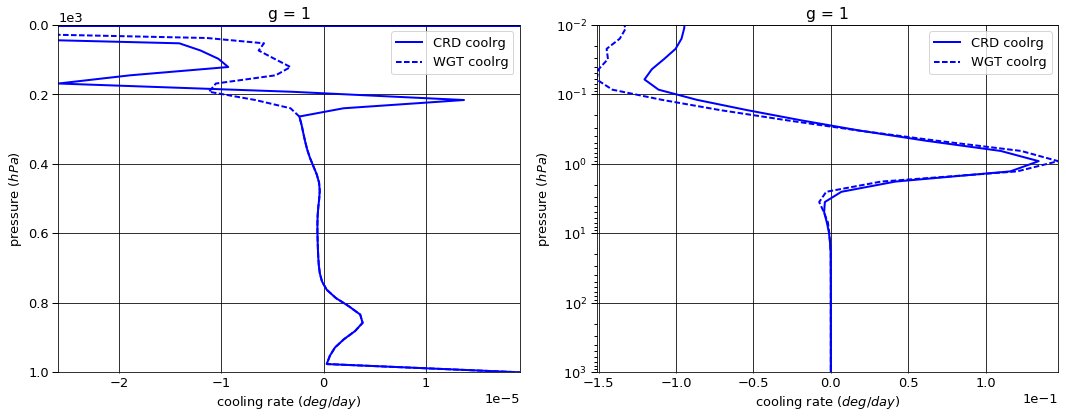

# Figure: cooling rate g-group 2

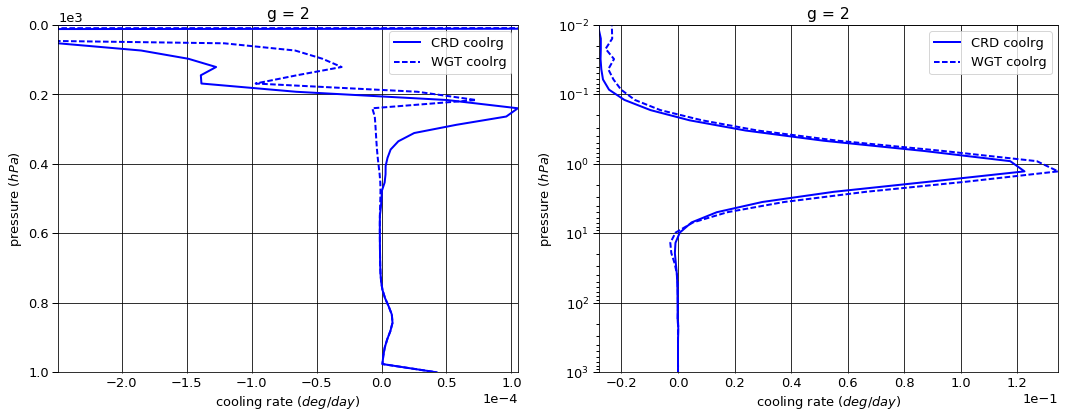

# Figure: cooling rate g-group 3

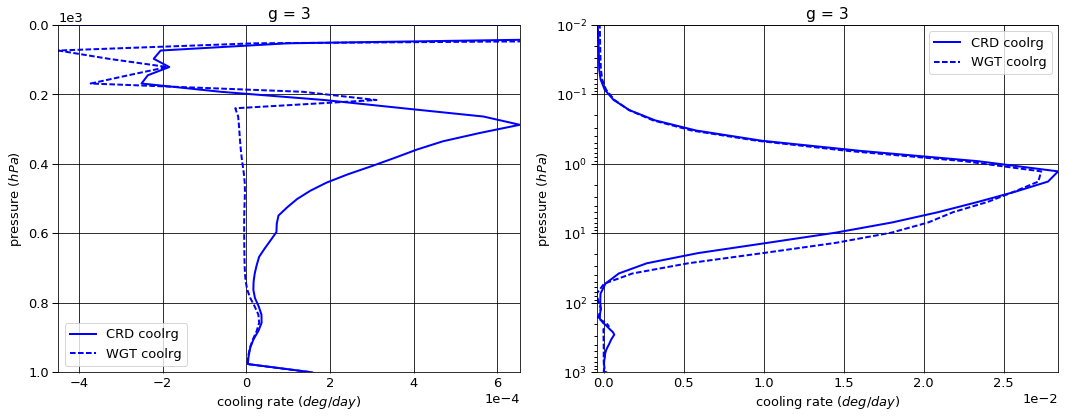

# Figure: cooling rate g-group 4

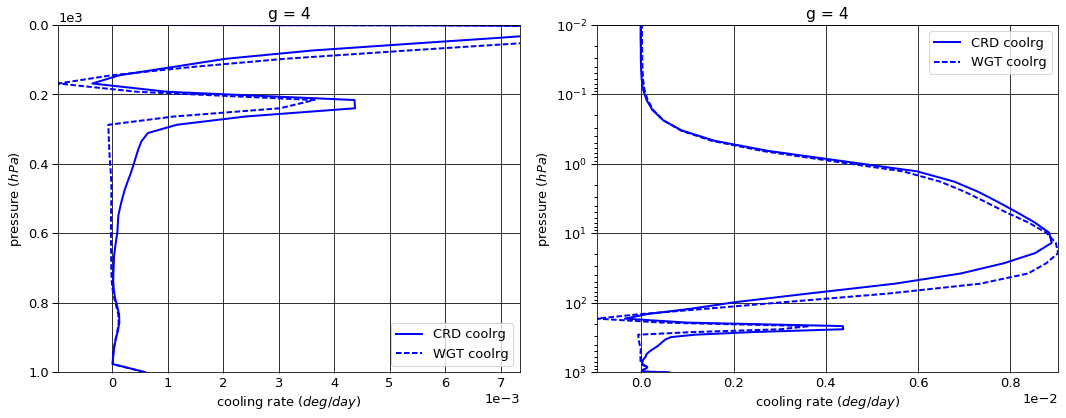

# Figure: cooling rate g-group 5

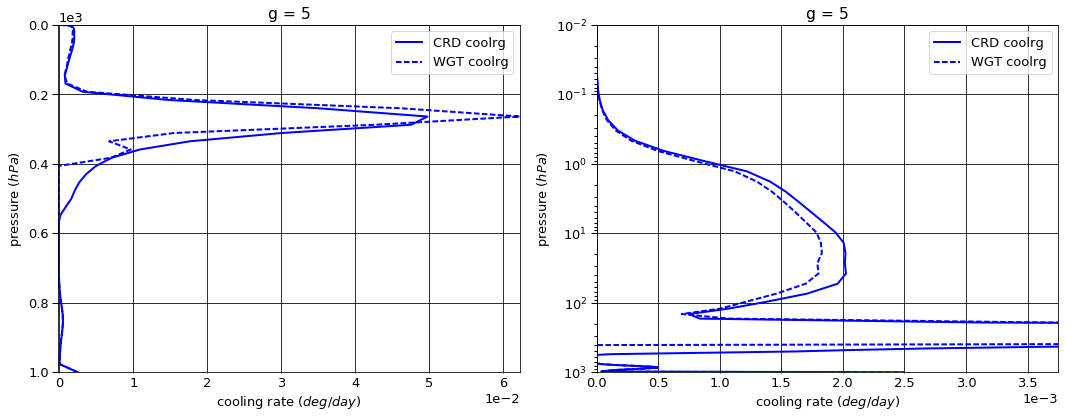

# Figure: cooling rate g-group 6

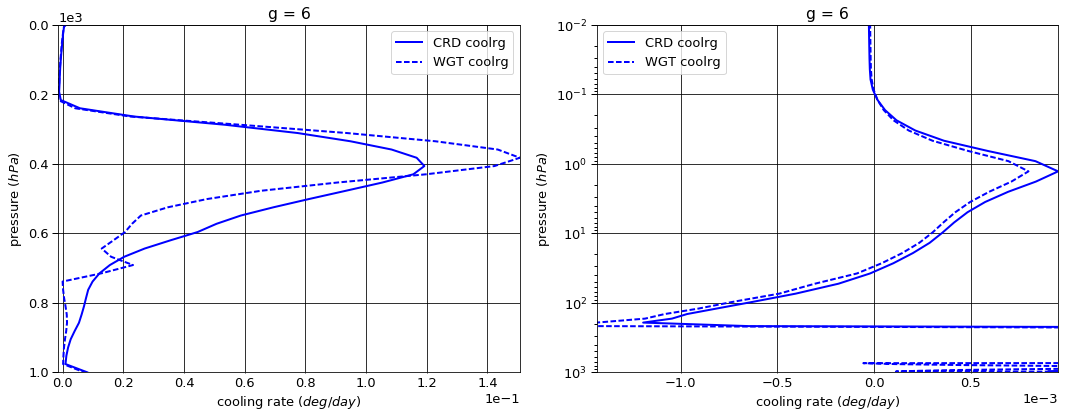

# Figure: cooling rate g-group 7

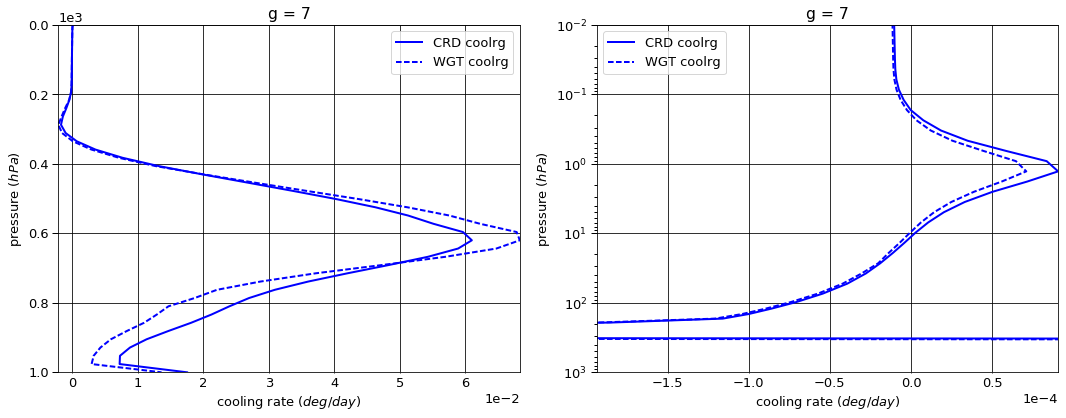

# Figure: cooling rate g-group total

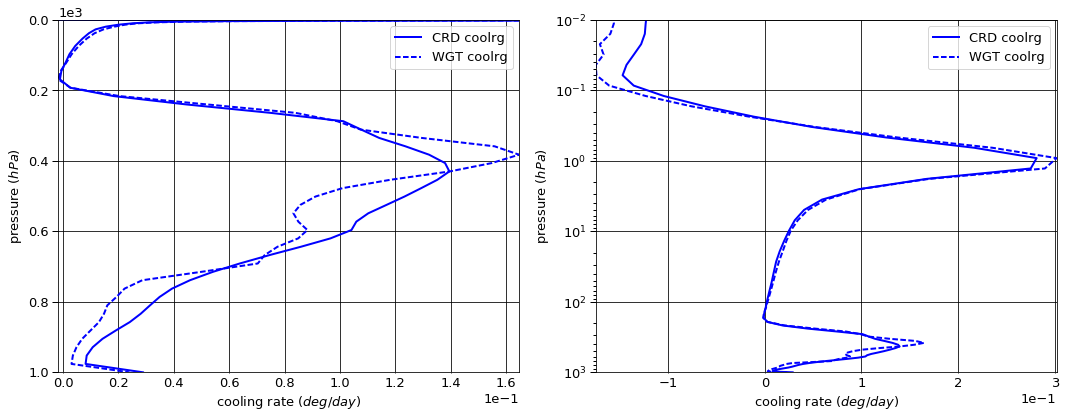

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.013192  -0.000081 -0.013272
  1013.0   76     -0.046136   0.046083 -0.000054
2 0.0      1      -0.029752   0.000000 -0.029752
  1013.0   76     -0.102373   0.102254 -0.000119
3 0.0      1      -0.052776   0.000000 -0.052776
  1013.0   76     -0.374788   0.374348 -0.000440
4 0.0      1      -0.124961   0.000000 -0.124961
  1013.0   76     -1.449447   1.447752 -0.001696
5 0.0      1      -0.702903   0.000000 -0.702903
  1013.0   76     -6.015176   6.008190 -0.006987
6 0.0      1      -3.924786   0.000000 -3.924786
  1013.0   76    -17.079470  17.057838 -0.021632
7 0.0      1      -2.426531   0.000000 -2.426531
  1013.0   76     -5.662107   5.600216 -0.061891


WGT


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011994   0.000000 -0.011994
  1013.0   76     -0.046136   0.046083 -0.000054
2 0.0      1      -0.033029   0.000000 -0.033029
  1013.0   76     -0.102373   0.102254 -0.000119
3 0.0      1      -0.049069   0.000000 -0.049069
  1013.0   76     -0.374788   0.374351 -0.000436
4 0.0      1      -0.111154   0.000000 -0.111154
  1013.0   76     -1.449447   1.447763 -0.001685
5 0.0      1      -0.643324   0.000000 -0.643324
  1013.0   76     -6.015176   6.008190 -0.006987
6 0.0      1      -3.548722   0.000000 -3.548722
  1013.0   76    -17.079470  17.059644 -0.019826
7 0.0      1      -2.293550   0.000000 -2.293550
  1013.0   76     -5.662107   5.625507 -0.036600


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001198  0.000081  0.001278
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1     -0.003276  0.000000 -0.003276
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1      0.003706  0.000000  0.003706
  1013.0   76     0.000000  0.000004  0.000004
4 0.0      1      0.013807  0.000000  0.013807
  1013.0   76     0.000000  0.000011  0.000011
5 0.0      1      0.059579  0.000000  0.059579
  1013.0   76     0.000000  0.000000  0.000000
6 0.0      1      0.376064  0.000000  0.376064
  1013.0   76     0.000000  0.001806  0.001806
7 0.0      1      0.132981  0.000000  0.132981
  1013.0   76     0.000000  0.025291  0.025291

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.108360
  1001.112500 75     0.000019
2 0.000312    1     -0.028329
  1001.112500 75     0.000042
3 0.000312    1     -0.000494
  1001.112500 75     0.000157
4 0.000312    1     -0.000037
  1001.112500 75     0.000606
5 0.000312    1     -0.000001
  1001.112500 75     0.002492
6 0.000312    1     -0.000033
  1001.112500 75     0.008070
7 0.000312    1     -0.000011
  1001.112500 75     0.017509


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.481394e-01
  1001.112500 75     1.915468e-05
2 0.000312    1     -2.209597e-02
  1001.112500 75     4.238868e-05
3 0.000312    1     -3.410553e-04
  1001.112500 75     1.556595e-04
4 0.000312    1      3.453432e-06
  1001.112500 75     6.008177e-04
5 0.000312    1     -3.454010e-07
  1001.112500 75     2.491786e-03
6 0.000312    1     -2.565119e-05
  1001.112500 75     7.070806e-03
7 0.000312    1     -1.218548e-05
  1001.112500 75     1.360844e-02


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.977938e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      6.232950e-03
  1001.112500 75     0.000000e+00
3 0.000312    1      1.532272e-04
  1001.112500 75    -1.782730e-06
4 0.000312    1      4.000554e-05
  1001.112500 75    -5.113380e-06
5 0.000312    1      1.143380e-06
  1001.112500 75     0.000000e+00
6 0.000312    1      7.354675e-06
  1001.112500 75    -9.990987e-04
7 0.000312    1     -9.291730e-07
  1001.112500 75    -3.900595e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.274901,-0.000081,-7.274982
1013.0,76,-30.729498,30.636680,-0.092819



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.690842,0.000000,-6.690842
1013.0,76,-30.729498,30.663792,-0.065707



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.584059,0.000081,0.584140
1013.0,76,0.000000,0.027112,0.027112


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.137266
1001.112500,75,0.028896



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.170611
1001.112500,75,0.023989



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.033346
1001.112500,75,-0.004907


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001452,0.001495
2,0.003240,0.003333
3,0.011856,0.012140
4,0.045250,0.047069
5,0.186990,0.195494
6,0.543010,0.556468
7,0.208192,0.183999


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.887171e-18
2,1.278086e-19
3,5.657798e-21
4,2.489067e-21
5,5.350613e-21
6,2.411227e-22
7,1.086608e-23


In [22]:
def spreadsheet():
    ng = 7
    ng_refs = [3, 1, 3]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.887171e-18,NaN,0.001452,0.001495,0.001452,0.001495,1.0
2,1.278086e-19,0.044268,0.003240,0.003333,0.004692,0.004828,1.0
3,5.657798e-21,0.044268,0.011856,0.012140,0.016548,0.016968,1.0
4,2.489067e-21,0.439936,0.045250,0.047069,0.061798,0.064037,10.0
5,5.350613e-21,2.149646,0.186990,0.195494,0.248788,0.259531,500.0
6,2.411227e-22,0.045065,0.543010,0.556468,0.791798,0.815999,500.0
7,1.086608e-23,0.045065,0.208192,0.183999,0.999990,0.999997,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog          ratio
layer g                                                        
1     1     0.000312  1.284203e-17  8.096439e-18       1.586133
      2     0.000312  4.829622e-19  2.126743e-20      22.709004
      3     0.000312  7.514164e-21  1.822211e-26  412365.240000
      4     0.000312  1.430185e-22  4.238604e-26    3374.189500
      5     0.000312  6.440577e-24  9.414002e-27     684.148660
      6     0.000312  8.937244e-24  6.160340e-28   14507.713000
      7     0.000312  4.434696e-24  6.608974e-29   67101.129000
2     1     0.000750  1.284314e-17  8.105630e-18       1.584472
      2     0.000750  4.844972e-19  3.127798e-20      15.490040
      3     0.000750  7.544920e-21  2.629421e-25   28694.227000
      4     0.000750  1.438790e-22  3.087175e-25     466.053880
      5     0.000750  6.474564e-24  3.291272e-26     196.719180
      6     0.000750  8.954728e-24  2.067517e-27    4331.150300
      7     0.000750  4.438764e-24  2.212075e-28   20066.064000
3     1     0.001052  1.284558e-17  8.125004e-18       1.580993
      2     0.001052  4.877202e-19  4.973000e-20       9.807363
      3     0.001052  7.602328e-21  4.514242e-24    1684.076200
      4     0.001052  1.450424e-22  5.243430e-25     276.617420
      5     0.001052  6.513121e-24  4.677615e-26     139.240190
      6     0.001052  8.989799e-24  3.325057e-27    2703.652800
      7     0.001052  4.447405e-24  3.410875e-28   13038.898000
4     1     0.001476  1.284801e-17  8.145352e-18       1.577342
      2     0.001476  4.911505e-19  2.018026e-19       2.433817
      3     0.001476  7.665164e-21  1.969205e-22      38.925169
      4     0.001476  1.463986e-22  1.016803e-24     143.979320
      5     0.001476  6.559940e-24  6.457862e-26     101.580690
      6     0.001476  9.027920e-24  5.431852e-27    1662.033500
      7     0.001476  4.456823e-24  5.565645e-28    8007.738800
5     1     0.002070  1.285026e-17  8.165556e-18       1.573715
      2     0.002070  4.946072e-19  2.069981e-19       2.389429
      3     0.002070  7.731027e-21  3.366972e-22      22.961363
      4     0.002070  1.479522e-22  2.664240e-24      55.532600
      5     0.002070  6.616413e-24  9.560210e-26      69.207821
      6     0.002070  9.067357e-24  7.692115e-27    1178.785800
      7     0.002070  4.466548e-24  7.638278e-28    5847.584600
6     1     0.002904  1.285233e-17  8.185596e-18       1.570115
      2     0.002904  4.980915e-19  2.115296e-19       2.354713
      3     0.002904  7.800779e-21  6.152924e-22      12.678165
      4     0.002904  1.497764e-22  4.074429e-24      36.760089
      5     0.002904  6.686245e-24  1.320632e-25      50.629138
      6     0.002904  9.108358e-24  1.059653e-26     859.560370
      7     0.002904  4.476593e-24  1.042776e-27    4292.955500
7     1     0.004074  1.285417e-17  8.205475e-18       1.566536
      2     0.004074  5.016099e-19  2.159654e-19       2.322640
      3     0.004074  7.875702e-21  7.331653e-22      10.742054
      4     0.004074  1.519748e-22  5.703760e-24      26.644669
      5     0.004074  6.774671e-24  1.820381e-25      37.215678
      6     0.004074  9.151313e-24  1.448596e-26     631.736480
      7     0.004074  4.486987e-24  1.423857e-27    3151.290600
8     1     0.005714  1.285577e-17  8.225195e-18       1.562975
      2     0.005714  5.051712e-19  2.204796e-19       2.291237
      3     0.005714  7.957589e-21  8.719293e-22       9.126416
      4     0.005714  1.546928e-22  7.675952e-24      20.152911
      5     0.005714  6.889029e-24  2.511029e-25      27.435080
      6     0.005714  9.196765e-24  1.979765e-26     464.538320
      7     0.005714  4.497769e-24  1.948602e-27    2308.203200
9     1     0.008015  1.285707e-17  8.244761e-18       1.559423
      2     0.008015  5.087887e-19  2.251756e-19       2.259519
      3     0.008015  8.048963e-21  1.037176e-21       7.760462
      4     0.008015  1.581343e-22  1.033655e-23      15.298551
      5     0.008015  7.039619e-24  3.466526

# Histogram of wavenumbers in g-group 1

In [31]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
